# 2018-10-09 Ensemble, Gradient, Boosting...

Le noteboook explore quelques particularités des algorithmes d'apprentissage pour expliquer certains résultats numériques. L'algoithme [AdaBoost](https://fr.wikipedia.org/wiki/AdaBoost) surpondère les exemples sur lequel un modèle fait des erreurs.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Skewed split train test

Lorsqu'une classe est sous représentée, il est difficile de prédire les résultats d'un modèle de machine learning.

In [3]:
import numpy, numpy.random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

N = 1000

res = []

for n in [1, 2, 5, 10, 20, 50, 80, 90, 100, 110]:
    print("n=", n)
    for k in range(10):

        X = numpy.zeros((N, 2))
        X[:, 0] = numpy.random.randint(0, 2, (N,))
        X[:, 1] = numpy.random.randint(0, n+1, (N,))
        Y = X[:, 0] + X[:, 1] + numpy.random.normal(size=(N,)) / 2
        Y[Y < 1.5] = 0
        Y[Y >= 1.5] = 1

        X_train, X_test, y_train, y_test = train_test_split(X, Y)

        stat = dict(N=N, n=n, ratio_train=y_train.sum()/y_train.shape[0],
                    k=k, ratio_test=y_test.sum()/y_test.shape[0])
        
        for model in [LogisticRegression(solver="liblinear"),
                      MLPClassifier(max_iter=500),
                      RandomForestClassifier(n_estimators=10),
                      AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=10)]:
            obs = stat.copy()
            obs["model"] = model.__class__.__name__
            if obs["model"] == "AdaBoostClassifier":
                obs["model"] = "AdaB-" + model.base_estimator.__class__.__name__
            try:
                model.fit(X_train, y_train)
            except ValueError as e:
                obs["erreur"] = str(e)
                res.append(obs)
                continue
            sc = model.score(X_test, y_test)
            obs["accuracy"] = sc
            conf = confusion_matrix(y_test, model.predict(X_test))
            try:
                obs["Error-0|1"] = conf[0, 1] / conf[0, :].sum()
                obs["Error-1|0"] = conf[1, 0] / conf[1, :].sum()
            except Exception:
                pass
            res.append(obs)

n= 1
n= 2
n= 5
n= 10
n= 20
n= 50
n= 80
n= 90
n= 100


c:\python370_x64\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in longlong_scalars
c:\python370_x64\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in longlong_scalars


n= 110


In [4]:
from pandas import DataFrame
df = DataFrame(res)
df = df.sort_values(['n', 'model', 'model', "k"]).reset_index(drop=True)
df["diff_ratio"] = (df["ratio_test"] - df["ratio_train"]).abs()
df.head(n=5)

,Error-0|1,Error-1|0,N,accuracy,k,model,n,ratio_test,ratio_train,diff_ratio
0,0.061798,0.208333,1000,0.896,0,AdaB-DecisionTreeClassifier,1,0.288,0.237333,0.050667
1,0.040230,0.302632,1000,0.880,1,AdaB-DecisionTreeClassifier,1,0.304,0.284000,0.020000
2,0.081395,0.256410,1000,0.864,2,AdaB-DecisionTreeClassifier,1,0.312,0.293333,0.018667
3,0.062147,0.342466,1000,0.856,3,AdaB-DecisionTreeClassifier,1,0.292,0.342667,0.050667
4,0.049180,0.298507,1000,0.884,4,AdaB-DecisionTreeClassifier,1,0.268,0.290667,0.022667


In [5]:
df.tail(n=5)

,Error-0|1,Error-1|0,N,accuracy,k,model,n,ratio_test,ratio_train,diff_ratio
395,0.00,0.0,1000,1.000,5,RandomForestClassifier,110,0.996,0.977333,0.018667
396,0.00,0.0,1000,1.000,6,RandomForestClassifier,110,0.972,0.990667,0.018667
397,0.00,0.0,1000,1.000,7,RandomForestClassifier,110,0.980,0.985333,0.005333
398,0.00,0.0,1000,1.000,8,RandomForestClassifier,110,0.988,0.980000,0.008000
399,0.25,0.0,1000,0.996,9,RandomForestClassifier,110,0.984,0.988000,0.004000


La répartition train/test est loin d'être statisfaisante lorsqu'il existe une classe sous représentée.

In [6]:
df[df.n==100][["n", "ratio_test", "ratio_train"]].head(n=10)

,n,ratio_test,ratio_train
320,100,1.000,0.986667
321,100,0.980,0.984000
322,100,0.984,0.984000
323,100,0.972,0.980000
324,100,0.984,0.981333
325,100,0.976,0.984000
326,100,0.984,0.990667
327,100,0.984,0.988000
328,100,0.980,0.989333
329,100,0.992,0.982667


In [7]:
#df.to_excel("data.xlsx")

In [8]:
columns = ["n", "N", "model"]
agg = df.groupby(columns, as_index=False).mean().sort_values(["n", "model"]).reset_index(drop=True)
agg.tail()

,n,N,model,Error-0|1,Error-1|0,accuracy,k,ratio_test,ratio_train,diff_ratio
35,100,1000,RandomForestClassifier,0.050000,0.002434,0.9968,4.5,0.9836,0.985067,0.006533
36,110,1000,AdaB-DecisionTreeClassifier,0.050000,0.002031,0.9972,4.5,0.9852,0.984667,0.007733
37,110,1000,LogisticRegression,0.261905,0.001216,0.9956,4.5,0.9852,0.984667,0.007733
38,110,1000,MLPClassifier,0.241905,0.001216,0.9948,4.5,0.9852,0.984667,0.007733
39,110,1000,RandomForestClassifier,0.083333,0.001626,0.9972,4.5,0.9852,0.984667,0.007733


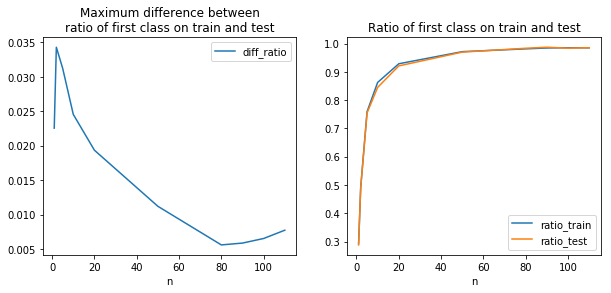

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
agg.plot(x="n", y="diff_ratio", ax=ax[0])
agg.plot(x="n", y="ratio_train", ax=ax[1])
agg.plot(x="n", y="ratio_test", ax=ax[1])
ax[0].set_title("Maximum difference between\nratio of first class on train and test")
ax[1].set_title("Ratio of first class on train and test")
ax[0].legend();

Une astuce pour éviter les doublons avant d'effecturer un pivot.

In [10]:
agg2 = agg.copy()
agg2["ratio_test2"] = agg2["ratio_test"] + agg2["n"] / 100000

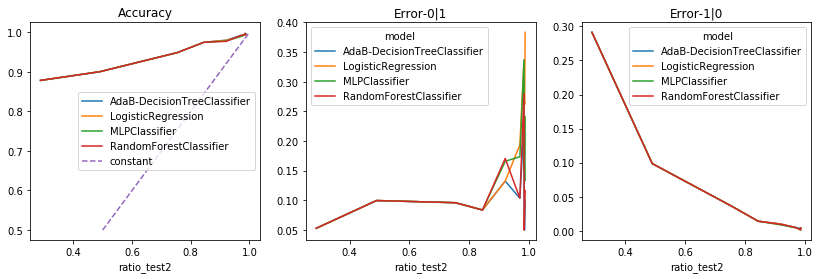

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14,4))
agg2.pivot("ratio_test2", "model", "accuracy").plot(ax=ax[0])
agg2.pivot("ratio_test2", "model", "Error-0|1").plot(ax=ax[1])
agg2.pivot("ratio_test2", "model", "Error-1|0").plot(ax=ax[2])
ax[0].plot([0.5, 1.0], [0.5, 1.0], '--', label="constant")
ax[0].set_title("Accuracy")
ax[1].set_title("Error-0|1")
ax[2].set_title("Error-1|0")
ax[0].legend();

In [12]:
agg2.pivot("ratio_test2", "model", "Error-0|1")

model,AdaB-DecisionTreeClassifier,LogisticRegression,MLPClassifier,RandomForestClassifier
ratio_test2,,,,
0.28801,0.052915,0.052915,0.052915,0.052915
0.49002,0.099708,0.099708,0.099708,0.099708
0.75445,0.096037,0.096037,0.096037,0.096037
0.84490,0.083750,0.083750,0.083750,0.083750
0.92100,0.132553,0.132553,0.165886,0.170648
0.97010,0.103611,0.193611,0.173611,0.103611
0.98400,0.230000,0.336667,0.336667,0.280000
0.98460,0.050000,0.270370,0.150000,0.050000
0.98630,0.050000,0.261905,0.241905,0.083333


Le modèle [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) construit 10 arbres tout comme la forêt aléatoire à ceci près que le poids associé à chacun des arbres des différents et non uniforme.

## Apprentissage continu

Apprendre une forêt aléatoire, puis ajouter un arbre, encore un tout en gardant le résultat des apprentissages précédents.

In [13]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = None
res = []
for i in range(0, 20):
    if model is None:
        model = RandomForestRegressor(n_estimators=1, warm_start=True)
    else:
        model.set_params(**dict(n_estimators=model.n_estimators+1))
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    res.append(dict(n_estimators=model.n_estimators, score=score))

In [16]:
df = DataFrame(res)
df.head()

,n_estimators,score
0,1,0.584034
1,2,0.760666
2,3,0.824477
3,4,0.811059
4,5,0.818055


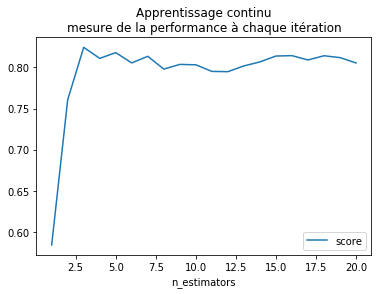

In [17]:
ax = df.plot(x="n_estimators", y="score")
ax.set_title("Apprentissage continu\nmesure de la performance à chaque itération");